**Import Libraries**

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

import datetime
from datetime import date
import random

import warnings

warnings.filterwarnings('ignore')

**Import Data**

In [2]:
data = pd.read_csv('./data/Metro_Interstate_Traffic_Volume.csv', infer_datetime_format=True)

In [4]:
data['date_time'] =  pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')

In [5]:
data = data.set_index(pd.DatetimeIndex(data['date_time'])).rename(columns={"date_time": "ds"}).drop_duplicates(subset=['ds'])

In [6]:
ts = data['2018-06-30':'2018-09-29']

In [7]:
ts.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,ds,traffic_volume
date_time,,,,,,,,,
2018-06-30 00:00:00,None,302.87,0.0,0.0,1,Clear,sky is clear,2018-06-30 00:00:00,1423
2018-06-30 01:00:00,None,302.58,0.0,0.0,1,Clear,sky is clear,2018-06-30 01:00:00,869
2018-06-30 02:00:00,None,302.55,0.0,0.0,1,Thunderstorm,proximity thunderstorm,2018-06-30 02:00:00,617
2018-06-30 03:00:00,None,302.29,0.0,0.0,40,Rain,moderate rain,2018-06-30 03:00:00,429
2018-06-30 04:00:00,None,301.29,0.0,0.0,1,Rain,light rain,2018-06-30 04:00:00,429


In [9]:
ts.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,2204.000000,2204.000000,2204.0,2204.000000,2204.000000
mean,293.953198,0.194410,0.0,37.094374,3329.777677
std,5.485298,0.688485,0.0,37.029980,1921.298260
min,274.250000,0.000000,0.0,0.000000,219.000000
25%,290.680000,0.000000,0.0,1.000000,1378.000000
50%,294.435000,0.000000,0.0,20.000000,3540.500000
75%,297.820000,0.000000,0.0,75.000000,4849.500000
max,306.080000,10.600000,0.0,90.000000,6837.000000


In [10]:
split_date = '2018-09-22'
ts_train = ts.loc[ts.index <= split_date].copy()
ts_test = ts.loc[ts.index > split_date].copy()

In [11]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [13]:
x_train = np.array(ts_train['traffic_volume'])
x_valid = np.array(ts_test['traffic_volume'])
series = np.concatenate((x_train, x_valid), axis=0)

time_train = np.array(ts_train['ds'])
time_valid = np.array(ts_test['ds'])
time = np.concatenate((time_train, time_valid), axis=0)

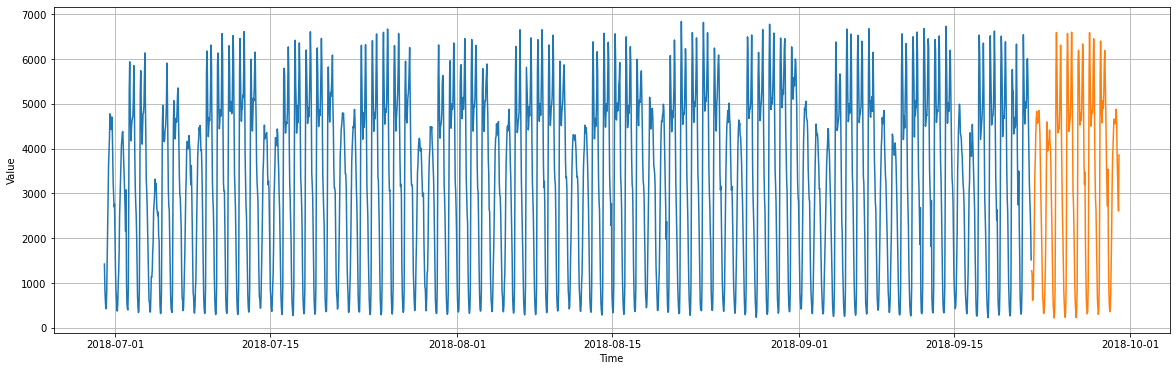

In [14]:
plt.figure(figsize=(20, 6))
plot_series(time_train, x_train)
plot_series(time_valid, x_valid)


In [15]:
print(len(time_train))
print(len(x_train))
print(len(time_valid))
print(len(x_valid))

2013
2013
191
191


In [16]:
window_size = 24
batch_size = 128
shuffle_buffer_size = 1000

In [17]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [18]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

# LSTM

In [27]:
tf.keras.backend.clear_session()

##
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=5,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    #tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L1(0.001)),
    tf.keras.layers.Lambda(lambda x: x * 10000)

])

In [28]:
%%bash
rm -rf ./logs/

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(monitor='val_mae', mode='min', verbose=1, patience=10, restore_best_weights=True)
rp = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

In [30]:
%%time
history = model.fit(train_set,validation_data=valid_set, epochs=300, callbacks=[es, rp, tb]) 

Epoch 1/300
16/16 [==============================] - 7s 112ms/step - loss: 3170.4829 - mae: 3170.9810 - val_loss: 2611.6440 - val_mae: 2612.1416 - lr: 0.0010
Epoch 2/300
16/16 [==============================] - 1s 35ms/step - loss: 1911.4318 - mae: 1911.9298 - val_loss: 2798.3484 - val_mae: 2798.8457 - lr: 0.0010
Epoch 3/300
16/16 [==============================] - 1s 34ms/step - loss: 974.8707 - mae: 975.3682 - val_loss: 1974.1014 - val_mae: 1974.5990 - lr: 0.0010
Epoch 4/300
16/16 [==============================] - 1s 33ms/step - loss: 648.8561 - mae: 649.3538 - val_loss: 1492.9912 - val_mae: 1493.4888 - lr: 0.0010
Epoch 5/300
16/16 [==============================] - 1s 35ms/step - loss: 547.4552 - mae: 547.9527 - val_loss: 989.1847 - val_mae: 989.6824 - lr: 0.0010
Epoch 6/300
16/16 [==============================] - 1s 34ms/step - loss: 490.4278 - mae: 490.9255 - val_loss: 760.9389 - val_mae: 761.4366 - lr: 0.0010
Epoch 7/300
16/16 [==============================] - 1s 35ms/step - l

16/16 [==============================] - 1s 36ms/step - loss: 184.6449 - mae: 185.1418 - val_loss: 121.4568 - val_mae: 121.9534 - lr: 2.0000e-04
Epoch 55/300
16/16 [==============================] - 1s 35ms/step - loss: 183.1424 - mae: 183.6393 - val_loss: 117.7509 - val_mae: 118.2478 - lr: 2.0000e-04
Epoch 56/300
16/16 [==============================] - 1s 35ms/step - loss: 188.4778 - mae: 188.9748 - val_loss: 119.7507 - val_mae: 120.2472 - lr: 2.0000e-04
Epoch 57/300
16/16 [==============================] - 1s 37ms/step - loss: 180.3415 - mae: 180.8384 - val_loss: 115.9721 - val_mae: 116.4692 - lr: 2.0000e-04
Epoch 58/300
16/16 [==============================] - 1s 35ms/step - loss: 186.5709 - mae: 187.0679 - val_loss: 129.5806 - val_mae: 130.0777 - lr: 2.0000e-04
Epoch 59/300
16/16 [==============================] - 1s 36ms/step - loss: 185.7765 - mae: 186.2735 - val_loss: 116.8461 - val_mae: 117.3428 - lr: 2.0000e-04
Epoch 60/300
16/16 [==============================] - 1s 41ms/ste

Epoch 106/300
16/16 [==============================] - 1s 35ms/step - loss: 175.6231 - mae: 176.1202 - val_loss: 112.4670 - val_mae: 112.9639 - lr: 1.0000e-04
Epoch 107/300
16/16 [==============================] - 1s 36ms/step - loss: 175.2697 - mae: 175.7665 - val_loss: 111.2630 - val_mae: 111.7593 - lr: 1.0000e-04
Epoch 108/300
16/16 [==============================] - 1s 36ms/step - loss: 175.0992 - mae: 175.5961 - val_loss: 115.8746 - val_mae: 116.3717 - lr: 1.0000e-04
Epoch 109/300
16/16 [==============================] - 1s 34ms/step - loss: 175.0058 - mae: 175.5028 - val_loss: 110.5210 - val_mae: 111.0172 - lr: 1.0000e-04
Epoch 110/300
16/16 [==============================] - 1s 34ms/step - loss: 176.5253 - mae: 177.0223 - val_loss: 112.0009 - val_mae: 112.4977 - lr: 1.0000e-04
Epoch 111/300
16/16 [==============================] - 1s 34ms/step - loss: 177.0387 - mae: 177.5356 - val_loss: 112.0038 - val_mae: 112.5006 - lr: 1.0000e-04
Epoch 112/300
16/16 [=========================

In [42]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [43]:
%%time
### summarize history for loss
split_time = 2013
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

Wall time: 628 ms


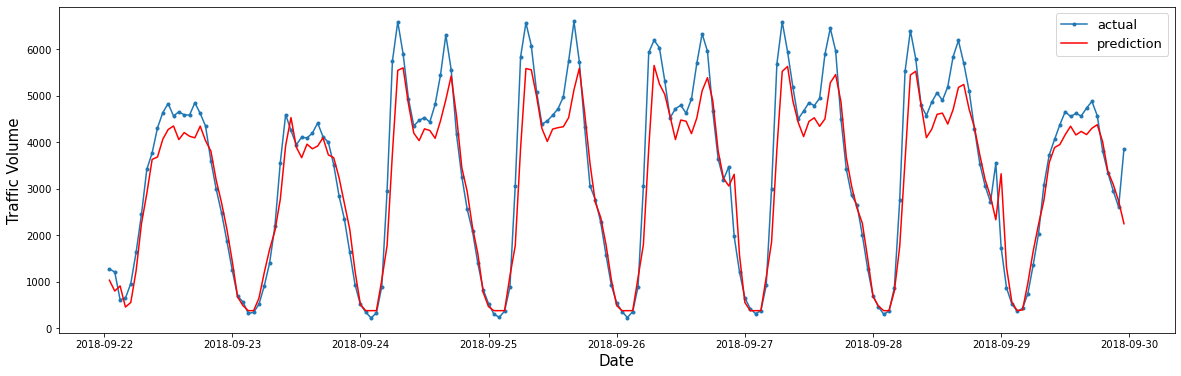

In [45]:
plt.figure(figsize=(20,6))
plt.plot(time_valid, x_valid, marker='.', label="actual")
plt.plot(time_valid, rnn_forecast, 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

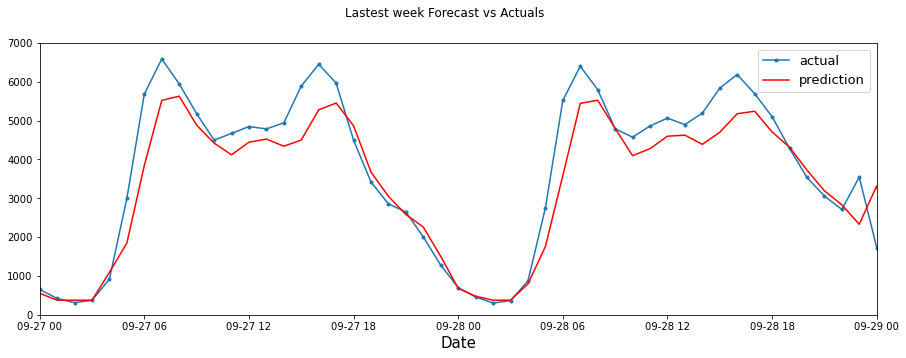

In [46]:
# zoom on lastest 2 days)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(time_valid, x_valid, marker='.', label="actual")
plt.plot(time_valid, rnn_forecast, 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,27), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 7000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')

In [47]:
from tensorflow.keras import backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

mae = tf.keras.metrics.mae(x_valid, rnn_forecast).numpy()
mape = tf.keras.metrics.mape(x_valid, rnn_forecast).numpy()
mse = tf.keras.metrics.mse(x_valid, rnn_forecast).numpy()
rmse = rmse(x_valid, rnn_forecast).numpy()
print(' MAE : {:.2f}'.format(mae))
print(' RMSE : {:.2f}'.format(rmse))
print(' MAPE : {:.2f} %'.format(mape))

 MAE : 426.53
 RMSE : 613.44
 MAPE : 14.62 %
